# Analyze Code Quality using Pylint

- compare overall pylint score across genders: t-test, since pylint score is continuous
- compare freuquency distribution of pylint messages across gender: chi-square test

In [2]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("SELECT * FROM translated_scratch_prompts_with_code", conn)
code = code.dropna(subset=['code'])
code = code[code['code'].str.strip() != '']
code = code.dropna(subset=['code'])
code = code[(code['gender'] == 'Woman (cisgender)') | (code['gender'] == 'Man (cisgender)')]
code = code[(code['programming_language'] == 'python')]

code

,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To use **Dummy Hot Encoding** (one-hot encodin...,import pandas as pd\nfrom sklearn.preprocessin...,chatgpt-4o-latest,python
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Absolutely! Here's how you can **split the `pe...,import pandas as pd\n\n# Assuming your datafra...,chatgpt-4o-latest,python
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can automate this in **Blender** using **P...,import bpy\nimport mathutils\n\n# === Configur...,chatgpt-4o-latest,python
5,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"In Python's `asyncio`, running a `Future` or c...",import asyncio\nimport inspect\n\nasync def my...,chatgpt-4o-latest,python
6,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Sure! Here's a short Python script you can use...,import pandas as pd\n\n# Read the CSV file\ndf...,chatgpt-4o-latest,python
...,...,...,...,...,...,...,...,...,...,...
233,234,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies `parse_obj` works ...,import pytest\nfrom pydantic import Validation...,deepseek-chat,python
234,235,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here's a Python function to count the number o...,import json\n\ndef count_json_objects(json_dat...,deepseek-chat,python
235,236,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,To merge these two dataframes based on the 'cl...,"merged_df = pd.merge(df_train_claim, df_train_...",deepseek-chat,python
236,237,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,To determine the best k for k-means clustering...,from sklearn.cluster import KMeans\n from sk...,deepseek-chat,python


## Define pylint and radon functions

In [3]:
from helpers.statistical_tests import compare_genders
from statsmodels.stats.multitest import multipletests
import tempfile
import subprocess
import re
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze

def run_pylint_on_code(code):
    with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as tmp:
        tmp.write(code)
        tmp_path = tmp.name
    try:
        result = subprocess.run(
            ['pylint', '--score=y', '--output-format=text', '--rcfile=.pylintrc', tmp_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        output = result.stdout
        errors = result.stderr
        # Extract score from output
        score_line = [line for line in output.split('\n') if 'Your code has been rated at' in line]
        if score_line:
            # Example: "Your code has been rated at 8.00/10"
            score = float(score_line[0].split(' ')[6].split('/')[0])
        else:
            score = None

        # Extract pylint codes using regex, e.g. W0611, C0114, etc.
        code_pattern = re.compile(r': ([A-Z]\d{4}):')
        pylint_codes = code_pattern.findall(output)

        # Save the full pylint output and stderr (just in case)
        messages = output.strip() + '\n' + errors.strip()
    finally:
        os.remove(tmp_path)  # Always clean up
    return score, messages, pylint_codes


def calc_radon_metrics(code):
    # Complexity
    try:
        complexity_data = cc_visit(code)
        cc_scores = [block.complexity for block in complexity_data] if complexity_data else [0]
        radon_complexity = float(sum(cc_scores) / len(cc_scores))
    except Exception:
        radon_complexity = None

    # MI index
    try:
        radon_maintainability_index = float(mi_visit(code, False))
    except Exception:
        radon_maintainability_index = None

    # Raw metrics
    try:
        raw = analyze(code)
        radon_loc = raw.loc
        radon_sloc = raw.sloc
        radon_lloc = raw.lloc
        radon_comments = raw.comments
    except Exception:
        radon_loc = radon_sloc = radon_lloc = radon_comments = None

    # Halstead metrics: volume, difficulty, effort, time required to program, bugs cannot be computed on this type of code since its only function calls

    return (radon_complexity, radon_maintainability_index, radon_loc, radon_sloc, radon_lloc, radon_comments)


def groupwise_comparison_with_correction(df, columns):
    p_vals = []
    test_types = []
    female_vars = []
    male_vars = []
    nonzero_females = []
    nonzero_males = []
    for col in columns:
        p_value, test_type, female_var, male_var, nonzero_female, nonzero_male = compare_genders(df, col)
        p_vals.append(p_value)
        test_types.append(test_type)
        female_vars.append(female_var)
        male_vars.append(male_var)
        nonzero_females.append(nonzero_female)
        nonzero_males.append(nonzero_male)
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'metric': columns,
        'test type': test_types,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'f_var': female_vars,
        'm_var': male_vars,
        'n_hits': [{'female': f, 'male': m} for f, m in zip(nonzero_females, nonzero_males)]
    })
    return results

## Analyze code

In [4]:
print("Running radon analysis on all code blocks...")
metrics = code['code'].apply(calc_radon_metrics)
columns = ['radon_complexity', 'radon_maintainability_index',
           'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments']
for idx, col in enumerate(columns):
    code[col] = metrics.apply(lambda vals: vals[idx])


print("Running pylint on all code blocks...")
code['pylint_score'], code['pylint_messages'], code['pylint_codes'] = zip(*code.apply(lambda row: run_pylint_on_code(row['code']), axis=1))

code


Running radon analysis on all code blocks...


<unknown>:11: SyntaxWarning: invalid escape sequence '\o'
<unknown>:11: SyntaxWarning: invalid escape sequence '\o'
<unknown>:26: SyntaxWarning: invalid escape sequence '\s'
<unknown>:26: SyntaxWarning: invalid escape sequence '\s'


Running pylint on all code blocks...


,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,radon_lloc,radon_comments,pylint_score,pylint_messages,pylint_codes
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To use **Dummy Hot Encoding** (one-hot encodin...,import pandas as pd\nfrom sklearn.preprocessin...,chatgpt-4o-latest,python,0.000000,100.000000,25,11,10,9,10.00,------------------------------------\nYour cod...,[]
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Absolutely! Here's how you can **split the `pe...,import pandas as pd\n\n# Assuming your datafra...,chatgpt-4o-latest,python,3.000000,100.000000,22,11,11,7,9.09,************* Module tmpfl53n38_\n/var/folders...,[C0116]
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can automate this in **Blender** using **P...,import bpy\nimport mathutils\n\n# === Configur...,chatgpt-4o-latest,python,3.000000,77.923560,71,46,46,13,8.89,************* Module tmpi0vn79uj\n/var/folders...,"[C0116, C0116, R1705, C0116, W0611]"
5,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"In Python's `asyncio`, running a `Future` or c...",import asyncio\nimport inspect\n\nasync def my...,chatgpt-4o-latest,python,2.666667,80.824245,36,31,31,5,8.28,************* Module tmpj8ke08z5\n/var/folders...,"[C0301, C0116, C0116, R1705, C0116]"
6,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Sure! Here's a short Python script you can use...,import pandas as pd\n\n# Read the CSV file\ndf...,chatgpt-4o-latest,python,0.000000,100.000000,14,6,7,4,10.00,------------------------------------\nYour cod...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,234,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies `parse_obj` works ...,import pytest\nfrom pydantic import Validation...,deepseek-chat,python,8.000000,88.994960,29,19,15,8,8.46,************* Module tmp_vanrafk\n/var/folders...,"[W0611, W0611]"
234,235,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here's a Python function to count the number o...,import json\n\ndef count_json_objects(json_dat...,deepseek-chat,python,3.000000,89.640541,42,21,22,9,8.95,************* Module tmp40bqbira\n/var/folders...,"[C0301, W1514]"
235,236,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,To merge these two dataframes based on the 'cl...,"merged_df = pd.merge(df_train_claim, df_train_...",deepseek-chat,python,0.000000,100.000000,1,1,1,0,10.00,------------------------------------\nYour cod...,[]
236,237,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,To determine the best k for k-means clustering...,from sklearn.cluster import KMeans\n from sk...,deepseek-chat,python,NaN,NaN,21,14,14,4,NaN,************* Module tmpy5xosb03\n/var/folders...,[E0001]


## Save to database

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

#one hot encoding for pylint scores
mlb = MultiLabelBinarizer()
binarized = pd.DataFrame(mlb.fit_transform(code['pylint_codes']),
                       columns=mlb.classes_,
                       index=code.index)
concatenated = pd.concat([code, binarized], axis=1)
cleaned = concatenated.drop(columns=['pylint_codes'])

code = cleaned

code.to_sql("pylint_scores", conn, if_exists="replace", index=False)

153

## Analyze Scores

### Cleaning out short files

In [6]:
code = code[code['radon_sloc'] >= 10]

In [7]:
users_per_gender = code.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),5
1,Woman (cisgender),8


In [8]:
prompts_per_user = code.groupby(['user_id', 'gender'])['message_text'].nunique().reset_index(name='num_prompts')
prompts_per_user

,user_id,gender,num_prompts
0,6,Man (cisgender),2
1,11,Woman (cisgender),1
2,16,Woman (cisgender),1
3,28,Woman (cisgender),3
4,34,Man (cisgender),3
5,46,Man (cisgender),1
6,48,Woman (cisgender),1
7,60,Woman (cisgender),3
8,65,Woman (cisgender),1
9,73,Woman (cisgender),3


In [9]:
print("Average pylint score (Female):", code[code['gender'] == 'Woman (cisgender)']['pylint_score'].mean())
print("Average pylint score (Male):", code[code['gender'] == 'Man (cisgender)']['pylint_score'].mean())

results = []

for model in code['model_version'].unique():
    model_df = code[code['model_version'] == model]
    res = groupwise_comparison_with_correction(
        model_df,
        [
            'pylint_score', 'radon_complexity', 'radon_maintainability_index',
            'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments'
        ]
    )
    res['model_version'] = model  # Add the model_version column
    results.append(res)

# Combine all into a single DataFrame
all_results = pd.concat(results, ignore_index=True)
all_results


Average pylint score (Female): 8.618157894736843
Average pylint score (Male): 7.909800000000001


,metric,test type,p_value,corrected p_value,f_var,m_var,n_hits,model_version
0,pylint_score,U-test,0.059938,0.069928,2.661441,2.157221,"{'female': 13, 'male': 8}",chatgpt-4o-latest
1,radon_complexity,U-test,0.174459,0.174459,2.480769,1.079365,"{'female': 6, 'male': 7}",chatgpt-4o-latest
2,radon_maintainability_index,U-test,0.055305,0.069928,115.056921,129.296978,"{'female': 13, 'male': 8}",chatgpt-4o-latest
3,radon_loc,T-test,0.032093,0.063171,160.901099,427.267857,"{'female': 14, 'male': 8}",chatgpt-4o-latest
4,radon_sloc,U-test,0.018339,0.063171,139.917582,231.357143,"{'female': 14, 'male': 8}",chatgpt-4o-latest
5,radon_lloc,U-test,0.018306,0.063171,99.670330,141.982143,"{'female': 14, 'male': 8}",chatgpt-4o-latest
6,radon_comments,T-test,0.036098,0.063171,6.263736,10.000000,"{'female': 14, 'male': 8}",chatgpt-4o-latest
7,pylint_score,U-test,0.314090,1.000000,4.704196,2.727562,"{'female': 11, 'male': 7}",o3-2025-04-16
8,radon_complexity,U-test,1.000000,1.000000,4.526136,0.702381,"{'female': 6, 'male': 7}",o3-2025-04-16
9,radon_maintainability_index,T-test,0.704230,1.000000,211.065045,191.643902,"{'female': 11, 'male': 7}",o3-2025-04-16


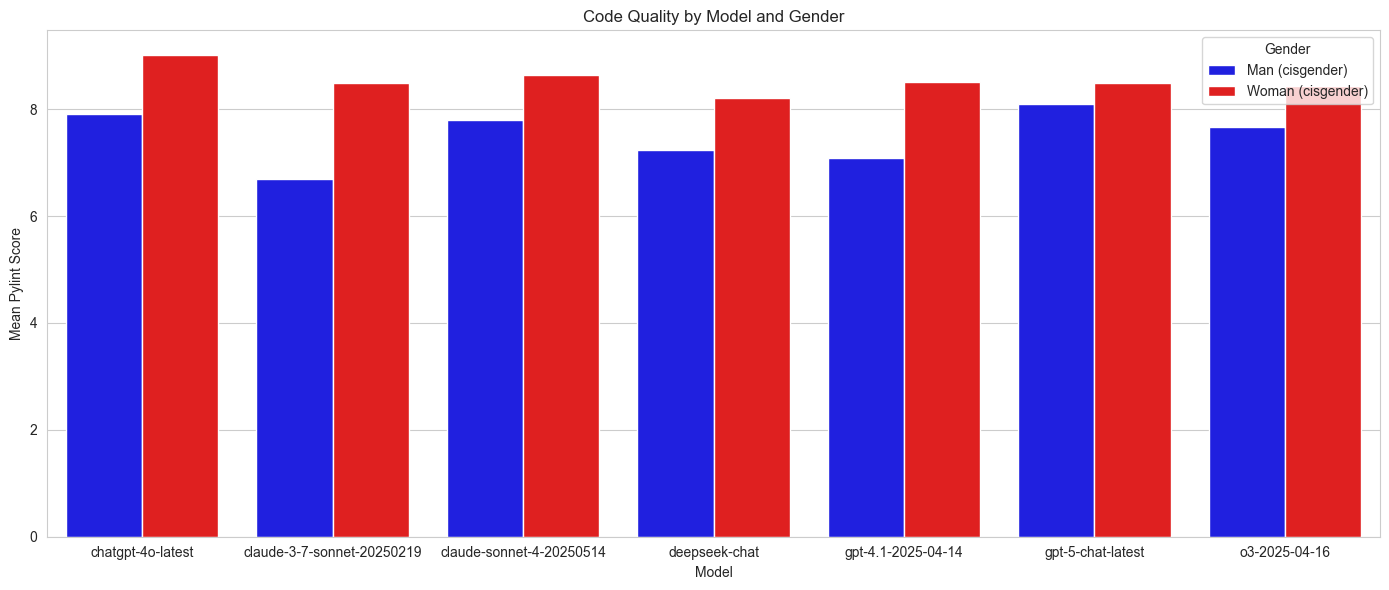

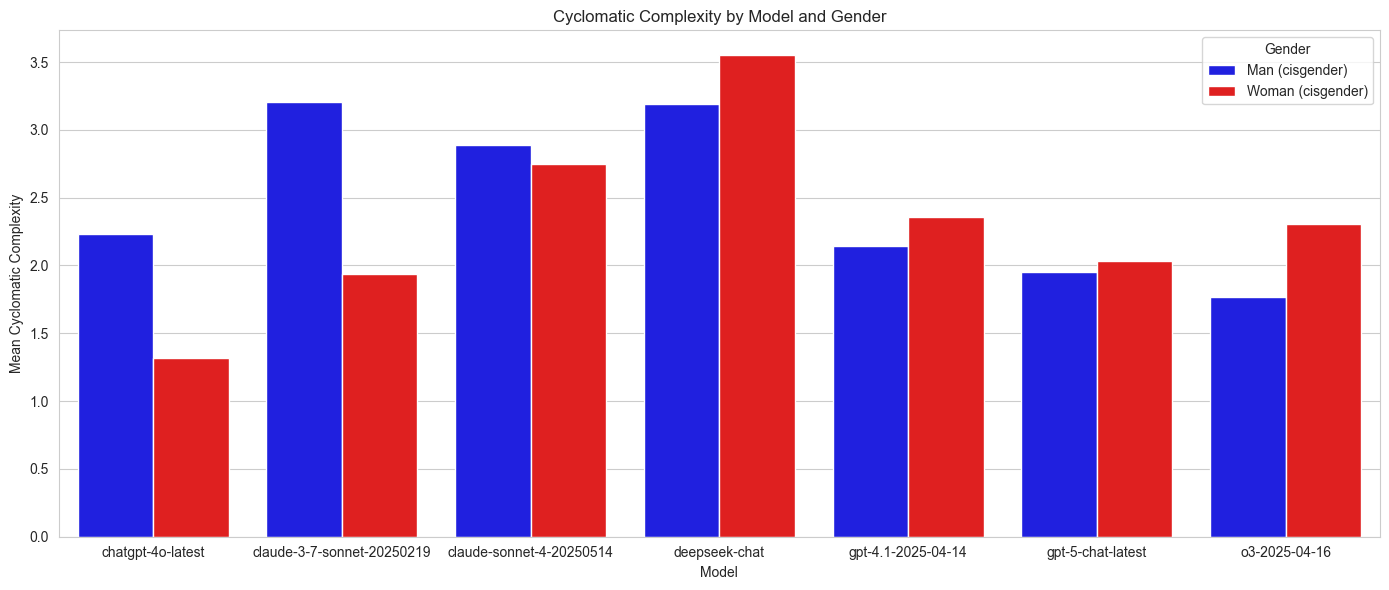

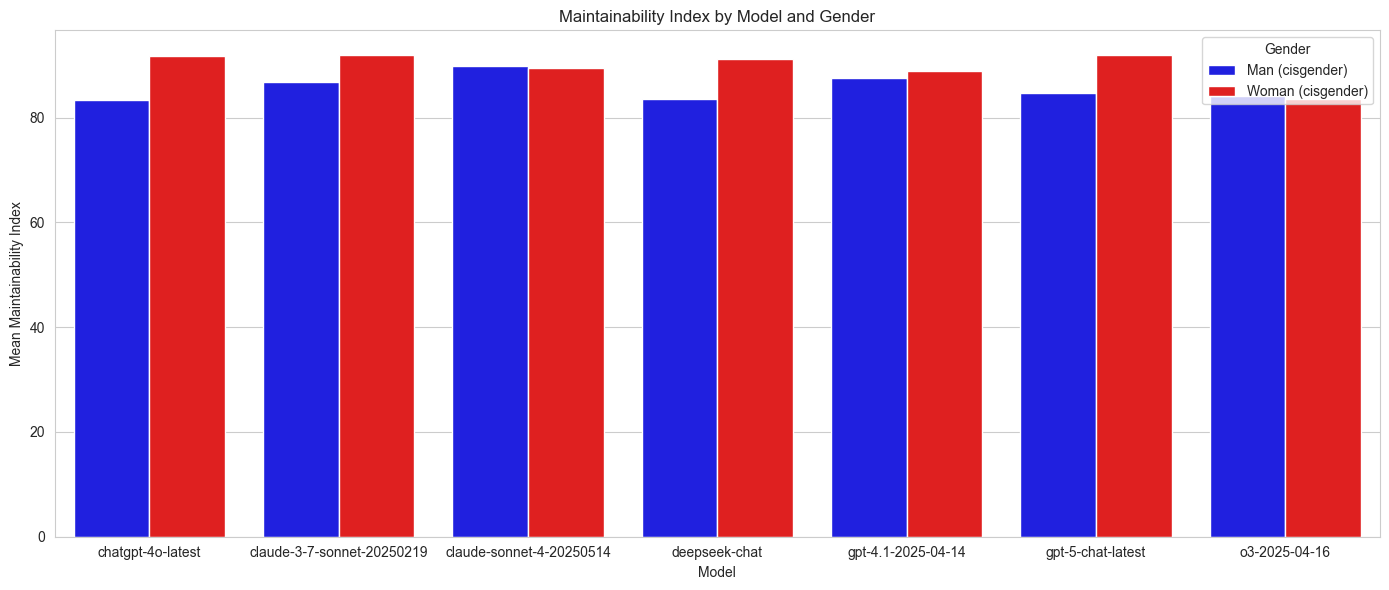

LLM: chatgpt-4o-latest
  Man (cisgender): 8
  Woman (cisgender): 14
LLM: claude-3-7-sonnet-20250219
  Man (cisgender): 7
  Woman (cisgender): 13
LLM: claude-sonnet-4-20250514
  Man (cisgender): 6
  Woman (cisgender): 7
LLM: deepseek-chat
  Man (cisgender): 8
  Woman (cisgender): 8
LLM: gpt-4.1-2025-04-14
  Man (cisgender): 8
  Woman (cisgender): 13
LLM: gpt-5-chat-latest
  Man (cisgender): 8
  Woman (cisgender): 14
LLM: o3-2025-04-16
  Man (cisgender): 7
  Woman (cisgender): 11


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Average pylint score per user, model and gender
user_avg = (
    code.groupby(['model_version', 'user_id', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

# 2. Compute mean per model and gender
plot_df = (
    user_avg.groupby(['model_version', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

# 3. Plot!
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df,
    x='model_version',
    y='pylint_score',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)

plt.xlabel('Model')
plt.ylabel('Mean Pylint Score')
plt.title('Code Quality by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# --- Plot Radon Cyclomatic Complexity ---

# Per-user, per-model, per-gender average
user_avg_complexity = (
    code.groupby(['model_version', 'user_id', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

# Mean per model and gender
plot_df_complexity = (
    user_avg_complexity.groupby(['model_version', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df_complexity,
    x='model_version',
    y='radon_complexity',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Model')
plt.ylabel('Mean Cyclomatic Complexity')
plt.title('Cyclomatic Complexity by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# --- Plot Radon Maintainability Index ---

user_avg_mi = (
    code.groupby(['model_version', 'user_id', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plot_df_mi = (
    user_avg_mi.groupby(['model_version', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df_mi,
    x='model_version',
    y='radon_maintainability_index',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Model')
plt.ylabel('Mean Maintainability Index')
plt.title('Maintainability Index by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

summary = code.groupby(['model_version', 'gender']).size().unstack(fill_value=0)
for llm, counts in summary.iterrows():
    print(f"LLM: {llm}")
    for gender, count in counts.items():
        print(f"  {gender}: {count}")


## Pylint Codes

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

# If needed: convert from JSON string (uncomment if 'pylint_codes' is a string)
#code['pylint_codes'] = code['pylint_codes'].apply(json.loads)

models = ["chatgpt-4o-latest", "o3-2025-04-16", "gpt-5-chat-latest", "gpt-4.1-2025-04-14", "claude-3-7-sonnet-20250219", "claude-sonnet-4-20250514"]

pattern = r'^[A-Z]\d{4}$'
pylint_code_columns = [col for col in code.columns if re.match(pattern, col)]
print("pylint codes: ", pylint_code_columns)

# chatgpt_4o = code[code['model_version'] == "chatgpt-4o-latest"]
# o3 = code[code['model_version'] == "o3-2025-04-16"]
# gpt_5 = code[code['model_version'] == "gpt-5-chat-latest"]
# gpt_4_1= code[code['model_version'] == "gpt-4.1-2025-04-14"]
# claude_3_7 = code[code['model_version'] == "claude-3-7-sonnet-20250219"]
# claude_4 = code[code['model_version'] == "claude-sonnet-4-20250514"]

def count_pylint_codes(df, model_version, code_columns):
    df = df[df['model_version'] == model_version]
    gender_counts = df.groupby('gender')[code_columns].sum().astype(int)
    gender_sizes = df.groupby('gender').size()
    gender_props = gender_counts.div(gender_sizes, axis=0)

    return gender_props

for model in code['model_version'].unique():
    print(count_pylint_codes(code, model, pylint_code_columns))


pylint codes:  ['C0103', 'C0115', 'C0116', 'C0301', 'C0321', 'C0325', 'C0410', 'C0411', 'C0412', 'C0415', 'C2801', 'E0001', 'E1142', 'R0903', 'R0913', 'R0914', 'R0917', 'R1705', 'R1724', 'R1728', 'R1732', 'R1735', 'R6003', 'W0104', 'W0212', 'W0237', 'W0311', 'W0401', 'W0611', 'W0612', 'W0613', 'W0702', 'W0707', 'W0718', 'W0719', 'W1201', 'W1203', 'W1309', 'W1401', 'W1514', 'W3101', 'W6001']
                      C0103     C0115     C0116  C0301  C0321  C0325  C0410  \
gender                                                                        
Man (cisgender)    0.250000  0.000000  0.875000   0.25    0.0  0.125    0.0   
Woman (cisgender)  0.142857  0.071429  0.285714   0.00    0.0  0.000    0.0   

                      C0411  C0412  C0415  ...  W0707     W0718  W0719  W1201  \
gender                                     ...                                  
Man (cisgender)    0.375000    0.0  0.125  ...    0.0  0.250000    0.0    0.0   
Woman (cisgender)  0.142857    0.0  0.000  ...

## Chi-square tests

### All pylint messages at once

In [12]:
from scipy.stats import chi2_contingency
grouped = code.groupby("gender")[pylint_code_columns].sum()
chi2, pval, dof, expected = chi2_contingency(grouped)

print(f"Chi2 = {chi2}, p = {pval}")


Chi2 = 74.36270688407505, p = 0.0011005688585565639


### Post hoc simple comparisions
- FDR correction needed!

In [13]:
results = []
for message_code in pylint_code_columns:
    table = pd.crosstab(code['gender'], code[message_code])
    # Make sure your table has both 'gender' rows and 0/1 columns
    if table.shape == (2, 2):  # Only if both genders and both present/absent
        chi2, p, dof, ex = chi2_contingency(table)
        results.append((message_code, chi2, p))
